In [116]:
import random
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

assert torch.cuda.is_available()
random.seed(42)
torch.manual_seed(42)
summary = SummaryWriter("runs/attention")

In [105]:
# CONSTANTS
CONTEXT_LEN = 128
BATCH_SIZE = 256
EMBED_LEN = 128
ADDED_PARAM_LEN = 2 # duration
PARAM_LEN = 1 + ADDED_PARAM_LEN
DROPOUT_RATE = 0.2

In [3]:
import cbor2
with open('embed-table-900-64.cbor', 'rb') as f:
    table = cbor2.load(f)
track_paths = glob.glob('/home/bob/vmshare/midi/solo-piano/*.mid.tokens')
# display(track_paths)
tracks = []
for path in track_paths:
    with open(path, 'rb') as f:
        tracks.append(cbor2.load(f))

In [4]:
VOCAB_SIZE =len(table)
print(tracks[0][0:5])
print(len(tracks))

[[2, 0.0, 0.0], [3, 0.0, 0.0]]
38


In [106]:
def build_dataset(tracks):
    X, Y = [], []
    for track in tracks:
        if len(track) < 100:
            continue
        context: list[int] = [1, 0.0, 0.0] * CONTEXT_LEN
        for token, beats, delay in track:
            X.append(context)
            Y.append(token)
            Y.append(beats)
            Y.append(delay)
            context = context[PARAM_LEN:] + [token, beats, delay]
    return torch.tensor(X, device='cuda').view(-1, CONTEXT_LEN, PARAM_LEN), torch.tensor(Y, device='cuda').view(-1, PARAM_LEN)

In [107]:
data = torch.tensor([(t, b, d) for track in tracks for t, b, d in track])
split_n = int(0.9 * len(data))
train_data = data[:split_n]
eval_data = data[split_n:]

In [109]:
def get_batch(split):
    data = train_data if split == 'train' else eval_data
    ix = torch.randint(len(data) - CONTEXT_LEN, (BATCH_SIZE,))
    x = torch.stack([data[i:i+CONTEXT_LEN] for i in ix])
    y = torch.stack([data[i+1:i+CONTEXT_LEN+1] for i in ix])
    return x.cuda(), y.cuda()

In [110]:
get_batch('train')[0].shape

torch.Size([256, 128, 3])

In [111]:
class Embedding:
    def __init__(self, num_embeddings, embeddings_dim) -> None:
        self.weight = torch.randn((num_embeddings, embeddings_dim), device="cuda")

    def __call__(self, IX):
        # print(IX.shape)
        ix = IX[:,:,0].int()
        added = IX[:,:,1:].view(-1, CONTEXT_LEN, ADDED_PARAM_LEN)
        # print(f"{ix=}")
        emb = self.weight[ix]
        self.out = torch.cat((emb, added), dim=2)
        # print(f"{self.out=}")
        # self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

class Linear:
    def __init__( self, fan_in: int, fan_out: int, bias=True, device="cuda"):
        self.device = device
        # Random initialization with kaiming-like normalization.
        self.weight = (
            torch.randn((fan_in, fan_out), device=device)
            / fan_in**0.5
        )
        self.bias = torch.zeros(fan_out, device=device) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    """\
    Batch Noemalization: Accelerating Deep Network Training by Reducing Internal
    Covariant Shift
    https://arxiv.org/abs/1502.03167

    Same as torch.nn.BatchNorm1d with:
        affine=True # will use beta and gamma
        track_running_stats=True
        device=whatever
        dtype=float
    """

    def __init__(self, dim, epsilon=1e-5, momentum=0.1, device="cuda"):
        self.device = device
        self.eps = epsilon
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim, device=device)
        self.beta = torch.zeros(dim, device=device)
        # buffers, trained with running "momentum update" for smoothing
        self.running_mean = torch.zeros(dim, device=device)
        # tracking variance instead of stddev
        self.running_var = torch.ones(dim, device=device)

    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean  # µB from paper
            xvar = self.running_var  # σ^2B from paper
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        # used for statistic collection, not part of torch
        self.out = self.gamma * xhat + self.beta
        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    """Same as torch.nn.Tanh"""

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

class Sequential:
    def __init__(self, *layers) -> None:
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [112]:
class SelfAttention(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(EMBED_LEN, head_size, bias=False)
        self.query = nn.Linear(EMBED_LEN, head_size, bias=False)
        self.value = nn.Linear(EMBED_LEN, head_size, bias=False)
        self.dropout = nn.Dropout(DROPOUT_RATE)
        self.register_buffer('tril', torch.tril(torch.ones(CONTEXT_LEN, CONTEXT_LEN)))

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)
        q = self.query(x)
        w = q @ k.transpose(-2, -1) * C**-0.5
        w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        w = F.softmax(w, dim=-1)
        w = self.dropout(w)
        v = self.value(x)
        out = w @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(head_size) for _ in range(num_heads)])
        self.projection = nn.Linear(num_heads * head_size, EMBED_LEN)
        self.dropout = nn.Dropout(DROPOUT_RATE)
    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.projection(out)
        out = self.dropout(out)
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(DROPOUT_RATE),
        )
    def forward(self, x):
        return self.net(x)

class SABlock(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed + ADDED_PARAM_LEN)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed + ADDED_PARAM_LEN)

    def forward(self, x):
        embeds = x[:,:,:-ADDED_PARAM_LEN]
        added = x[:,:,-ADDED_PARAM_LEN:].view(-1, CONTEXT_LEN, ADDED_PARAM_LEN)
        x = embeds + self.sa(self.ln1(embeds))
        x = torch.cat((x, added), dim=2)
        x = x + self.ffwd(self.ln2(x))
        return x

In [113]:
class Model(nn.Module):
    def __init__(self, n_hidden_neurons, n_sa_heads=4):
        super().__init__()
        self.token_embedding_table = nn.Embedding(VOCAB_SIZE, EMBED_LEN)
        self.position_embedding_table = nn.Embedding(CONTEXT_LEN, EMBED_LEN)
        # self.sa_head = SelfAttention(EMBED_LEN)
        self.blocks = nn.Sequential(
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
            SABlock(EMBED_LEN, 4),
        )
        #self.sa_heads = MultiHeadAttention(n_sa_heads, EMBED_LEN // n_sa_heads)
        #self.ffwd = FeedForward(EMBED_LEN + ADDED_PARAM_LEN)
        self.lm_head = Linear((EMBED_LEN + ADDED_PARAM_LEN), VOCAB_SIZE, bias=False)
        
    def forward(self, x, targets=None):
        B, T, C = x.shape
        tokens = x[:,:,0].long()
        added = x[:,:,1:].view(-1, CONTEXT_LEN, ADDED_PARAM_LEN)
        tok_emb = self.token_embedding_table(tokens)
        pos_emb = self.position_embedding_table(torch.arange(T, device='cuda'))
        x = tok_emb + pos_emb
        x = torch.cat((x, added), dim=2)
        x = self.blocks(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            classes = targets[:, :, 0].long()
            added_params = targets[:, :, 1:]
            label_loss = F.cross_entropy(logits.view(B*T, C), classes.view(B*T))
            sq_err = ((added_params[:, :, -ADDED_PARAM_LEN:] - logits[:, :, -ADDED_PARAM_LEN:]) ** 2)
            added_param_loss = sq_err.mean()
            loss = label_loss + added_param_loss
        return logits, loss

    def generate(self, idx, max_new_tokens):
        model.eval()
        out = []
        for _ in range(max_new_tokens):
            idx = idx[:, -CONTEXT_LEN:] # truncate context
            logits, loss = self(idx)
            probs = F.softmax(logits[:, -1, :VOCAB_SIZE], dim=-1)
            next_token = torch.multinomial(probs, num_samples=1) # B, 1
            token = next_token.int().item()
            added_params = logits[:,-1,-ADDED_PARAM_LEN:].view(1, 2)
            next_idx = torch.cat((next_token, added_params), dim=-1) # B, 3
            out.append([token] + added_params.tolist()[0])
            idx = torch.cat((idx, next_idx.view(1, -1, 3)), dim=1)
            if next_token.item() == 3:
                break
        return out


In [120]:
model = Model(BATCH_SIZE).cuda()
summary.add_graph(model, get_batch('train'))
global_training_steps = 0

In [132]:
lossi = []
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5)
max_steps = 100_000
# print(sum(1 for p in model.parameters()))
# assert Xtrain.device == 'cuda:0', Xtrain.device
for i in range(max_steps+1):
    global_training_steps += 1
    Xb, Yb = get_batch('train')
    # forward
    #if logits.isnan().any():
    #    print("NAN ALERT")
    #    break
    logits, loss = model(Xb, Yb)
    if i % 100 == 0:
        summary.add_scalar('loss', loss.item(), global_training_steps)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    # track

    if i % 1_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 100000: 0.0892
   1000/ 100000: 0.0861
   2000/ 100000: 0.0856
   3000/ 100000: 0.0805
   4000/ 100000: 0.0838
   5000/ 100000: 0.0835
   6000/ 100000: 0.0860
   7000/ 100000: 0.0806
   8000/ 100000: 0.0830
   9000/ 100000: 0.0821
  10000/ 100000: 0.0811
  11000/ 100000: 0.0821
  12000/ 100000: 0.0898
  13000/ 100000: 0.0840
  14000/ 100000: 0.0807
  15000/ 100000: 0.0857
  16000/ 100000: 0.0785
  17000/ 100000: 0.0796
  18000/ 100000: 0.0848
  19000/ 100000: 0.0816
  20000/ 100000: 0.0814
  21000/ 100000: 0.0823
  22000/ 100000: 0.0867
  23000/ 100000: 0.0811
  24000/ 100000: 0.0843
  25000/ 100000: 0.0822
  26000/ 100000: 0.0815
  27000/ 100000: 0.0856
  28000/ 100000: 0.0830
  29000/ 100000: 0.0820
  30000/ 100000: 0.0820
  31000/ 100000: 0.0825
  32000/ 100000: 0.0796
  33000/ 100000: 0.0801
  34000/ 100000: 0.0846
  35000/ 100000: 0.0829
  36000/ 100000: 0.0840
  37000/ 100000: 0.0803
  38000/ 100000: 0.0794
  39000/ 100000: 0.0811
  40000/ 100000: 0.0778
  41000/ 100000:

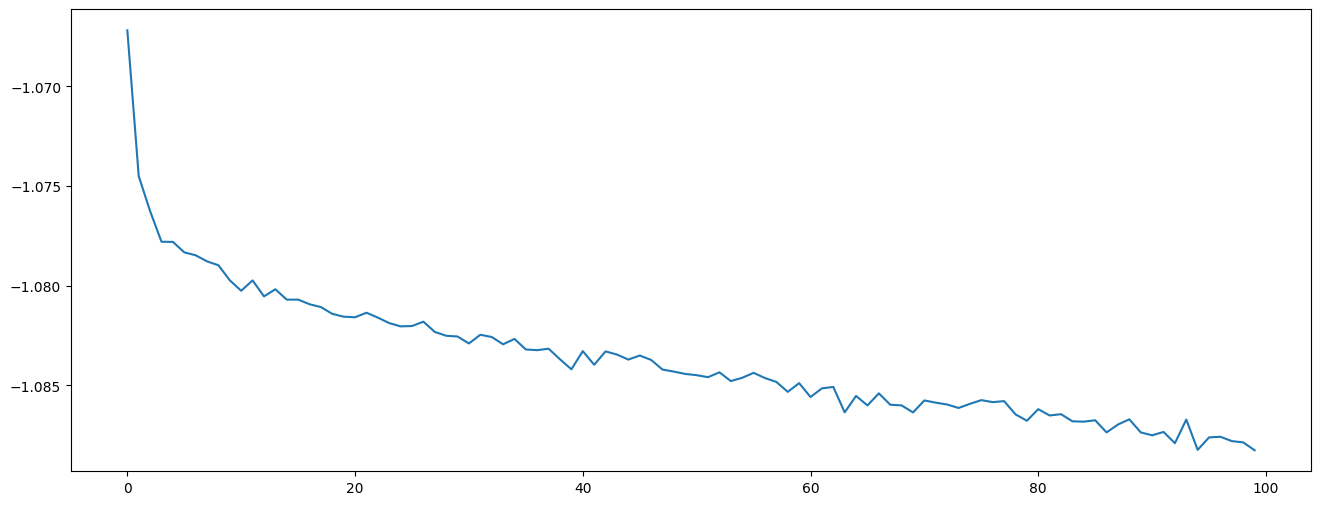

In [133]:
plt.figure(figsize=(16, 6))
# instead, average across 1_000 points
plt.plot(torch.tensor(lossi)[:-1].view(-1, 1000).mean(1))


In [134]:
for sample in range(1):
    gen_ctx = torch.tensor([[[1, 0.0, 0.0]] * (CONTEXT_LEN - 1) + [[2, 0.0, 0.0]]], device='cuda')
    generated = model.generate(gen_ctx, max_new_tokens=1_000)
    with open(f"sample-{sample}.tokens", 'wb') as f:
        cbor2.dump(generated, f)
        print("wrote", f.name)

wrote sample-0.tokens


In [145]:
@torch.no_grad()
def split_loss(split):
    model.eval()
    data = {
        "train": train_data,
        "eval": eval_data,
    }[split]
    ix = torch.randint(len(data) - CONTEXT_LEN, (BATCH_SIZE,))
    x = torch.stack([data[i:i+CONTEXT_LEN] for i in ix]).cuda()
    y = torch.stack([data[i+1:i+CONTEXT_LEN+1] for i in ix]).cuda()
    logits, loss = model(x, y)
    print(split, loss.item())
    model.train()

split_loss("train")
split_loss("eval")

train 0.043405480682849884
eval 12.46329116821289
